In [1]:
!pip install pandas numpy matplotlib tensorflow==2.16.1 tkan==0.2.0 tkat scikit-learn pyarrow

In [2]:
import time
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Flatten

from tkan import TKAN, BSplineActivation
from tkat import TKAT

from sklearn.metrics import r2_score

from utils.minmaxscaler import MinMaxScaler # utils is the folder next to this file, change it with your scaler if not using the whole folder or copy the class

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()


2024-06-04 11:51:26.750609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_parquet('/workspace/data.parquet')
df = df[(df.index >= pd.Timestamp('2020-01-01')) & (df.index < pd.Timestamp('2023-01-01'))]
assets = ['BTC', 'ETH', 'ADA', 'XMR', 'EOS', 'MATIC', 'TRX', 'FTM', 'BNB', 'XLM', 'ENJ', 'CHZ', 'BUSD', 'ATOM', 'LINK', 'ETC', 'XRP', 'BCH', 'LTC']
df = df[[c for c in df.columns if 'quote asset volume' in c and any(asset in c for asset in assets)]]
df.columns = [c.replace(' quote asset volume', '') for c in df.columns]
known_input_df = pd.DataFrame(index=df.index, data=np.array([df.reset_index()['group'].apply(lambda x: (x.hour)).values, df.reset_index()['group'].apply(lambda x: (x.dayofweek)).values]).T, columns = ['hour', 'dayofweek'])
display(df)
display(known_input_df)


,BTC,ADA,XMR,EOS,CHZ,MATIC,TRX,ENJ,FTM,BNB,XLM,BUSD,ATOM,LTC,LINK,ETC,ETH,XRP,BCH
group,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,3.675857e+06,38189.176211,4.539598e+04,94778.577031,817.146319,31003.791035,481993.354990,15241.945783,1165.788613,8.498617e+05,9460.819556,1.352376e+04,31986.972694,1.165827e+05,24281.170262,56488.402352,1.000930e+06,2.579254e+05,178258.749391
2020-01-01 01:00:00,6.365953e+06,51357.010954,3.348395e+04,593292.135445,886.460339,84465.335718,533668.554562,11896.843688,413.844612,7.405759e+05,37141.909518,2.531605e+04,81777.666046,2.830715e+05,51190.975142,182102.074213,1.474278e+06,4.520609e+05,615321.025242
2020-01-01 02:00:00,4.736719e+06,36164.263914,1.573255e+04,266732.556000,1819.795050,113379.718506,387049.986770,30109.770521,3559.965968,1.039091e+06,16878.822627,1.390886e+04,195731.175551,2.402871e+05,28721.756184,134063.422732,9.940256e+05,4.414948e+05,221535.645771
2020-01-01 03:00:00,5.667367e+06,24449.953815,2.575105e+04,124516.579473,2979.655803,41771.707995,450772.139235,6732.833578,4076.415482,4.975018e+05,9049.223394,2.251969e+04,120113.343316,1.613043e+05,29596.222534,131094.172168,6.473610e+05,1.886061e+05,397185.950571
2020-01-01 04:00:00,3.379094e+06,44502.669843,6.295563e+04,421819.671410,1023.388675,22254.756114,284788.973752,846.938455,633.367505,4.751285e+05,7254.260203,1.122460e+04,19989.169106,2.214516e+05,54514.370016,134937.122201,4.430067e+05,2.279373e+05,316499.137509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,6.704605e+07,581680.400510,3.873989e+05,48359.865300,199491.822800,890911.573610,225136.420055,40281.859330,159553.944500,9.889098e+05,39230.588600,6.560756e+06,180809.784710,9.964355e+05,190664.976300,181340.756100,7.738029e+06,1.413563e+06,35409.149500
2022-12-31 20:00:00,4.344849e+07,323561.762270,1.379392e+05,37858.704700,173057.240300,333511.762200,157069.026827,42228.830930,270251.374500,6.032059e+05,52964.531800,7.255324e+06,276013.421720,1.173164e+06,265727.950340,90513.087600,4.278879e+06,1.113527e+06,42674.516600
2022-12-31 21:00:00,5.992803e+07,455185.698060,2.445869e+05,79538.050600,107544.609700,525037.759990,180404.744820,27446.620810,198885.610000,1.386864e+06,44485.594800,8.712142e+06,476151.071190,6.820723e+05,265687.852060,85399.066100,4.643401e+06,1.373231e+06,38027.858800


,hour,dayofweek
group,,
2020-01-01 00:00:00,0,2
2020-01-01 01:00:00,1,2
2020-01-01 02:00:00,2,2
2020-01-01 03:00:00,3,2
2020-01-01 04:00:00,4,2
...,...,...
2022-12-31 19:00:00,19,5
2022-12-31 20:00:00,20,5
2022-12-31 21:00:00,21,5


In [ ]:
N_MAX_EPOCHS = 100
BATCH_SIZE = 128
early_stopping_callback = lambda : tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=6,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=6,
)
lr_callback = lambda : tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=3,
    mode="min",
    min_delta=0.00001,
    min_lr=0.000025,
    verbose=0,
)
callbacks = lambda : [early_stopping_callback(), lr_callback(), tf.keras.callbacks.TerminateOnNaN()]


In [ ]:
def generate_data(df, sequence_length, n_ahead):
    #Case without known inputs
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median()
    tmp_df = df.copy() / scaler_df
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    def prepare_sequences(df, scaler_df, n_history, n_future):
        X, y, y_scaler = [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            X.append(df.iloc[i - n_history:i].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        X, y, y_scaler = np.array(X), np.array(y), np.array(y_scaler)
        return X, y, y_scaler
    
    # Prepare sequences
    X, y, y_scaler = prepare_sequences(tmp_df, scaler_df, sequence_length, n_ahead)
    
    # Split the dataset into training and testing sets
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]
    
    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)
    
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test

def generate_data_w_known_inputs(df, known_input_df, sequence_length, n_ahead):
    #Case without known inputs - fill with 0 the unknown features future values in X
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median()
    tmp_df = df.copy() / scaler_df
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    tmp_known_input_df = known_input_df.iloc[24 * 14 + n_ahead:].copy()
    def prepare_sequences(df, known_input_df, scaler_df, n_history, n_future):
        Xu, Xk, y, y_scaler = [], [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            Xu.append(np.concatenate((df.iloc[i - n_history:i].values, np.zeros((n_future, df.shape[1]))), axis=0))
            Xk.append(known_input_df.iloc[i - n_history:i+n_future].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        Xu, Xk, y, y_scaler = np.array(Xu), np.array(Xk), np.array(y), np.array(y_scaler)
        return Xu, Xk, y, y_scaler
    
    # Prepare sequences
    Xu, Xk, y, y_scaler = prepare_sequences(tmp_df, tmp_known_input_df, scaler_df, sequence_length, n_ahead)

    X = np.concatenate((Xu, Xk), axis=-1)
    
    # Split the dataset into training and testing sets
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]
    
    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)
    
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test

In [4]:
num_hidden = 100
num_heads = 4
num_embedding = 1
n_ahead = 30
sequence_length = 5 * n_ahead

X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data_w_known_inputs(df, known_input_df, sequence_length, n_ahead)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20607, 180, 21), (5152, 180, 21), (20607, 30), (5152, 30))

# TKAT usage

In [5]:

num_unknow_features = len(assets)
num_know_features = X_train.shape[2] - num_unknow_features

model = TKAT(sequence_length, num_unknow_features, num_know_features, num_embedding, num_hidden, num_heads, n_ahead, use_tkan = True)

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose = False)

preds = model.predict(X_test).flatten()
errors = preds - y_test.flatten()
rmse = np.sqrt(np.mean(np.square(errors)))
r2 = r2_score(y_true=y_test.flatten(), y_pred=preds)
mae = np.mean(np.abs(errors))

metrics_summary = f"""
Model Type: TKAT
------------------------------------
Root Mean Squared Error (RMSE): {rmse:.4f}
R-squared (R²) Score: {r2:.4f}
Mean Absolute Error (MAE): {mae:.4f}
"""
print(metrics_summary)

all_errors = {}
preds = model.predict(X_test)
errors = preds-y_test
all_errors['TKAT'] = errors

2024-06-04 11:51:34.504405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 11:51:34.509008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 11:51:34.509148: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 21)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 180, 1,    │          0 │ input_layer[0][0] │
│ (EmbeddingLayer)    │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ past_observed_and_… │ (None, 150, 1,    │          0 │ embedding_layer[… │
│ (Lambda)            │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vsn_past_features   │ (None, 150, 100)  │    665,946 │ past_observed_an… │
│ (VariableSelection… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_known        │ (None, 30, 1, 2)  │          0 │ embedding_layer[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 150,      │     60,810 │ vsn_past_feature… │
│ (RecurrentLayer)    │ 100), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100), (None, 1)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vsn_future_features │ (None, 30, 100)   │     72,614 │ future_known[0][… │
│ (VariableSelection… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 30, 100)   │     60,810 │ vsn_future_featu… │
│ (RecurrentLayer)    │                   │            │ encoder[0][1],    │
│                     │                   │            │ encoder[0][2],    │
│                     │                   │            │ encoder[0][3]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 180, 100)  │          0 │ encoder[0][0],    │
│ (Concatenate)       │                   │            │ decoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gate_25 (Gate)      │ (None, 180, 100)  │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 180, 100)  │          0 │ vsn_past_feature… │
│ (Concatenate)       │                   │            │ vsn_future_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_and_norm_25     │ (None, 180, 100)  │        200 │ gate_25[0][0],    │
│ (AddAndNorm)        │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grn_25 (GRN)        │ (None, 180, 100)  │          0 │ add_and_norm_25[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 180, 100)  │    161,300 │ grn_25[0][0],     │
│ (MultiHeadAttentio… │                   │            │ grn_25[0][0],     │
│                     │                   │            │ grn_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18000)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 30)        │    540,030 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,561,710 (5.96 MB)

 Trainable params: 1,561,704 (5.96 MB)

 Non-trainable params: 6 (24.00 B)

I0000 00:00:1717501924.327416   35144 service.cc:145] XLA service 0x193ff680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717501924.327447   35144 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-04 11:52:05.237776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-04 11:52:08.056515: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1717501942.670029   35144 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_87', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_82', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1717501942.714852   35144 device_compiler.h:188]

161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

Model Type: TKAT
------------------------------------
Root Mean Squared Error (RMSE): 0.0669
R-squared (R²) Score: 0.1277
Mean Absolute Error (MAE): 0.0287

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


## Other example comparison

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_6 (TKAN)                   │ (None, 150, 100)       │        36,905 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_7 (TKAN)                   │ (None, 100)            │        62,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,355 (399.82 KB)

 Trainable params: 102,355 (399.82 KB)

 Non-trainable params: 0 (0.00 B)

161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 2850)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 100)            │       285,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,230 (1.14 MB)

 Trainable params: 298,230 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 150, 100)       │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,930 (390.35 KB)

 Trainable params: 99,930 (390.35 KB)

 Non-trainable params: 0 (0.00 B)

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 150, 100)       │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_357 (Dense)               │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,430 (513.40 KB)

 Trainable params: 131,430 (513.40 KB)

 Non-trainable params: 0 (0.00 B)

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


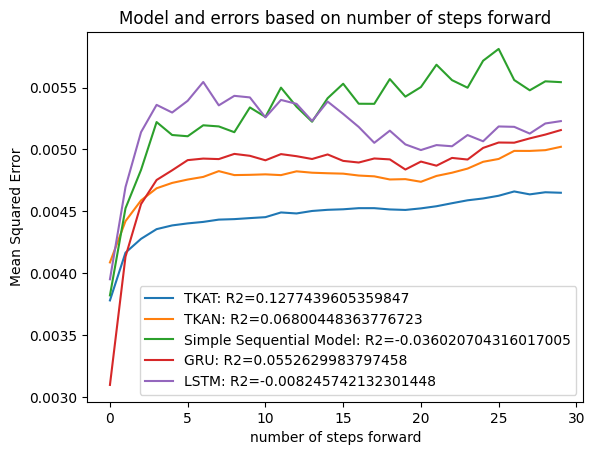

In [14]:
models = ['TKAN', 'MLP', 'GRU', 'LSTM']


for model_type in models:
    
    X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data(df, sequence_length, n_ahead)

    if 'TKAN' in model_type:
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
            TKAN(100, tkan_activations=[BSplineActivation(i) for i in range(5)], return_sequences=True),
            TKAN(100, tkan_activations=[BSplineActivation(i) for i in range(5)], return_sequences=False),
            tf.keras.layers.Dense(y_train.shape[1], activation='linear'),
        ])
    elif 'GRU' in model_type:
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
            GRU(100, return_sequences=True),
            GRU(100, return_sequences=False),
            tf.keras.layers.Dense(y_train.shape[1], activation='linear'),
        ])
    elif 'LSTM' in model_type:
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
            LSTM(100, return_sequences=True),
            LSTM(100, return_sequences=False),
            tf.keras.layers.Dense(y_train.shape[1], activation='linear'),
        ])
    elif 'MLP' in model_type:
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
            Flatten(),
            Dense(100, activation='relu'),
            Dense(100, activation='relu'),
            tf.keras.layers.Dense(y_train.shape[1], activation='linear'),
        ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.summary()

    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose = False)
    preds = model.predict(X_test)
    errors = preds-y_test
    all_errors[model_type] = errors

for model_type in all_errors:
    y_pred = all_errors[model_type] + y_test
    r2 = r2_score(y_true=y_test.flatten(), y_pred=y_pred.flatten())
    plt.plot(np.mean(all_errors[model_type]**2, axis=0), label=f'{model_type}: R2={r2}')
plt.legend()
plt.title('Model and errors based on number of steps forward')
plt.xlabel('number of steps forward')
plt.ylabel('Mean Squared Error')
plt.show()